In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import plot_model
from PIL import Image
from IPython.display import display, clear_output
import ipywidgets as widgets
import io
from keras import layers
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [2]:
# Load data and preprocess images
labels = ['glioma', 'meningioma', 'neurocytoma', 'notumor', 'pituitary', 'schwannoma']
X = []
y = []
image_size = 256

for i in labels:
    folderPath = os.path.join('Tumor1/Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

X = np.array(X)
y = np.array(y)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 793/793 [00:00<00:00, 850.62it/s]


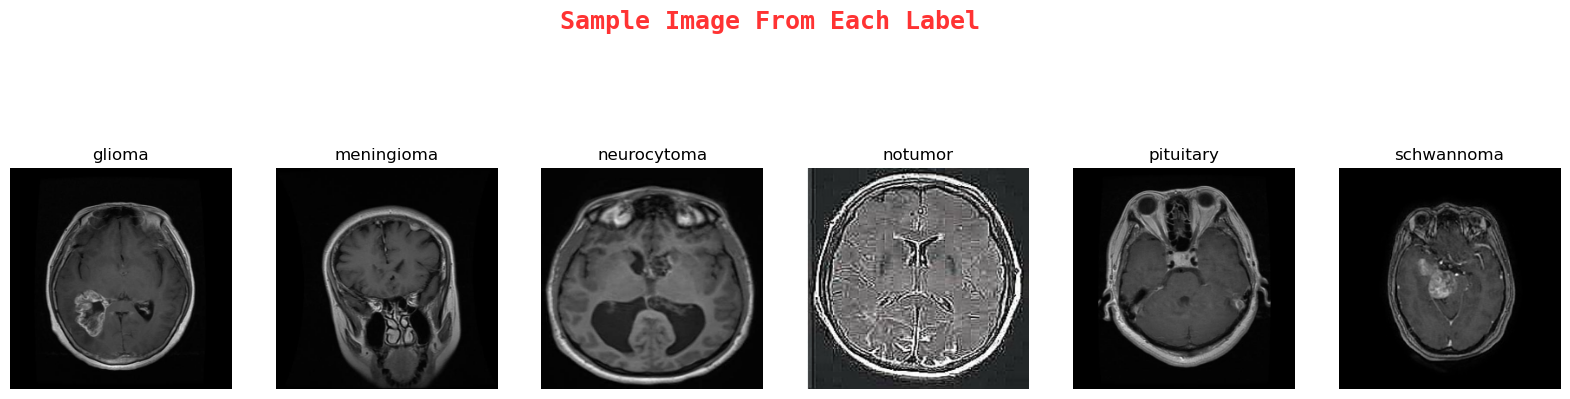

In [3]:
k=0
fig, ax = plt.subplots(1,6,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color= 'r',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y[j]==i:
            ax[k].imshow(X[j])
            ax[k].set_title(y[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [4]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [5]:
print("X_train:",X_train.shape)
print("X_test:",X_test.shape)
print("y_train:",y_train.shape)
print("y_test:",y_test.shape)

X_train: (6615, 256, 256, 3)
X_test: (736, 256, 256, 3)
y_train: (6615,)
y_test: (736,)


In [6]:
def extract_hog_features(images):
    hog_features = []
    for img in tqdm(images):
        # Convert the image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Compute HOG features
        hog_feature, _ = hog(gray_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')
        hog_features.append(hog_feature)
    return np.array(hog_features)

In [7]:
# Check if the HOG features are already computed and saved
if os.path.exists('X_train_hog1.npy') and os.path.exists('X_test_hog1.npy'):
    X_train_hog = np.load('X_train_hog1.npy')
    X_test_hog = np.load('X_test_hog1.npy')
else:
    # Extract HOG features from training and testing images
    X_train_hog = extract_hog_features(X_train)
    X_test_hog = extract_hog_features(X_test)

    # Normalize the data (optional but often recommended)
    X_train_hog = X_train_hog / 255.0
    X_test_hog = X_test_hog / 255.0

    # Save the HOG features to disk
    np.save('X_train_hog1.npy', X_train_hog)
    np.save('X_test_hog1.npy', X_test_hog)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 736/736 [01:08<00:00, 10.73it/s]


In [8]:
# Label Encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [9]:
# Apply Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_hog, y_train_encoded)
rf_predictions = rf_classifier.predict(X_test_hog)

In [10]:
# Apply Support Vector Machine (SVM) Classifier
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_classifier.fit(X_train_hog, y_train_encoded)
svm_predictions = svm_classifier.predict(X_test_hog)

In [11]:
# Apply K-Nearest Neighbors (KNN) Classifier
knn_classifier = KNeighborsClassifier(n_neighbors=20)
knn_classifier.fit(X_train_hog, y_train_encoded)
knn_predictions = knn_classifier.predict(X_test_hog)

In [12]:
# Apply Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_hog, y_train_encoded)
dt_predictions = dt_classifier.predict(X_test_hog)

In [13]:
# Apply Logistic Regression Classifier
lr_classifier = LogisticRegression(max_iter=1000, random_state=42)
lr_classifier.fit(X_train_hog, y_train_encoded)
lr_predictions = lr_classifier.predict(X_test_hog)

In [14]:
# Apply XGBoost Classifier
xgb_classifier = XGBClassifier(n_estimators=100, random_state=42)
xgb_classifier.fit(X_train_hog, y_train_encoded)
xgb_predictions = xgb_classifier.predict(X_test_hog)

In [15]:
def evaluate_classifier(predictions, y_true, classifier_name):
    print(f"Evaluation for {classifier_name}:\n")
    print("Classification Report:\n")
    print(classification_report(y_true, predictions, target_names=label_encoder.classes_))
    print("Confusion Matrix:\n")
    print(confusion_matrix(y_true, predictions))

# Evaluate all classifiers
evaluate_classifier(rf_predictions, y_test_encoded, "Random Forest")
evaluate_classifier(svm_predictions, y_test_encoded, "SVM")
evaluate_classifier(knn_predictions, y_test_encoded, "KNN")
evaluate_classifier(dt_predictions, y_test_encoded, "Decision Tree")
evaluate_classifier(lr_predictions, y_test_encoded, "Logistic Regression")
evaluate_classifier(xgb_predictions, y_test_encoded, "XGBoost")


Evaluation for Random Forest:

Classification Report:

              precision    recall  f1-score   support

      glioma       0.93      0.84      0.88       132
  meningioma       0.81      0.81      0.81       134
 neurocytoma       0.99      0.98      0.98        85
     notumor       0.93      0.94      0.93       160
   pituitary       0.88      0.94      0.91       146
  schwannoma       0.99      1.00      0.99        79

    accuracy                           0.91       736
   macro avg       0.92      0.92      0.92       736
weighted avg       0.91      0.91      0.91       736

Confusion Matrix:

[[111  18   0   0   3   0]
 [  3 109   0  10  12   0]
 [  1   0  83   1   0   0]
 [  1   3   1 150   4   1]
 [  4   4   0   1 137   0]
 [  0   0   0   0   0  79]]
Evaluation for SVM:

Classification Report:

              precision    recall  f1-score   support

      glioma       0.94      0.89      0.92       132
  meningioma       0.85      0.87      0.86       134
 neurocytoma

/Users/abi/tensorflow-test/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/abi/tensorflow-test/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/abi/tensorflow-test/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
rf_accuracy = accuracy_score(y_test_encoded, rf_predictions)
svm_accuracy = accuracy_score(y_test_encoded, svm_predictions)
knn_accuracy = accuracy_score(y_test_encoded, knn_predictions)
dt_accuracy = accuracy_score(y_test_encoded, dt_predictions)
lr_accuracy = accuracy_score(y_test_encoded, lr_predictions)
xgb_accuracy = accuracy_score(y_test_encoded, xgb_predictions)

In [17]:
# Print accuracies
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"KNN Accuracy: {knn_accuracy:.4f}")
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

Random Forest Accuracy: 0.9090
SVM Accuracy: 0.9375
KNN Accuracy: 0.8804
Decision Tree Accuracy: 0.7826
Logistic Regression Accuracy: 0.5815
XGBoost Accuracy: 0.9348


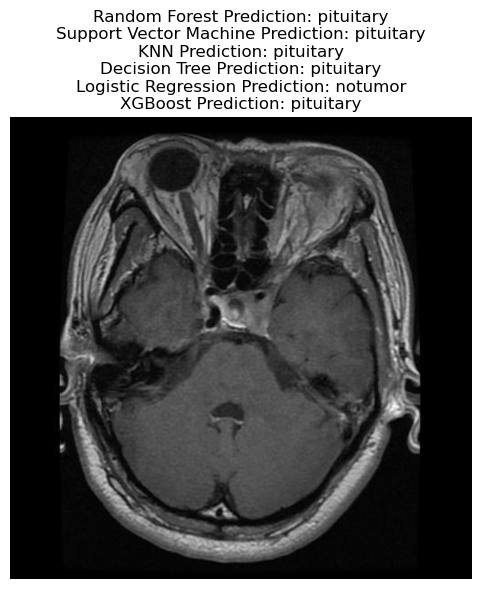

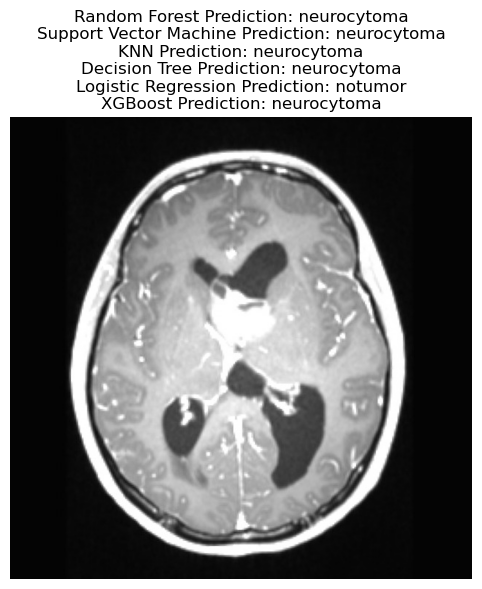

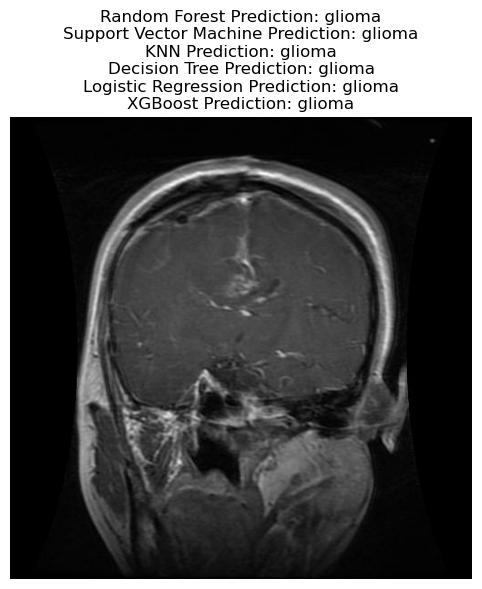

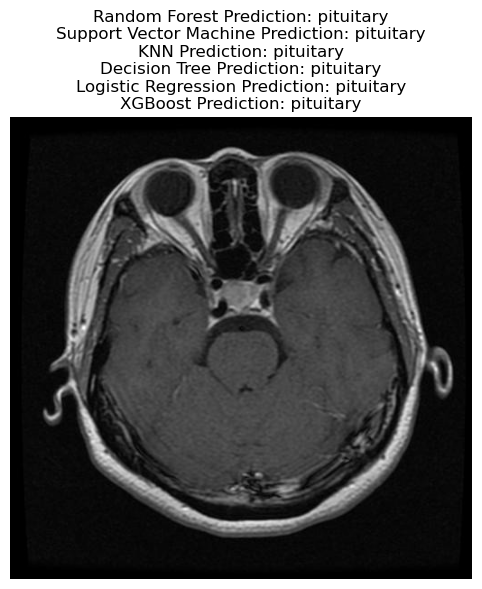

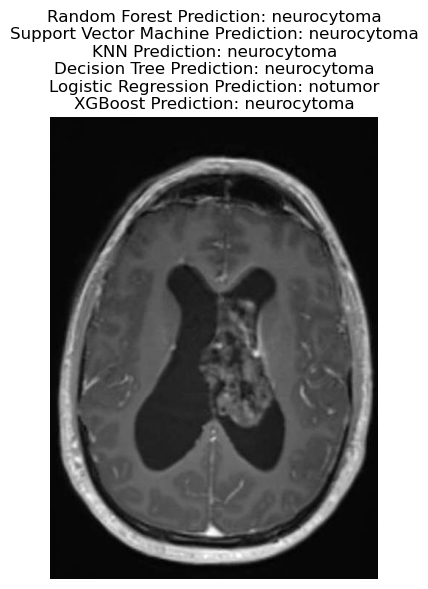

In [18]:
# Load the trained models
model_rf = rf_classifier
model_svm = svm_classifier
model_knn = knn_classifier
model_dt = dt_classifier
model_lr = lr_classifier
model_xgb = xgb_classifier

# Function to predict tumor type for a given image
def predict_tumor_type(model, image):
    # Preprocess the image (resize and extract HOG features)
    image = cv2.resize(image, (image_size, image_size))
    hog_feature, _ = hog(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')
    hog_feature = hog_feature.reshape(1, -1) / 255.0

    # Make prediction
    prediction = model.predict(hog_feature)
    return prediction[0]

# Function to display the image and its predicted tumor type
def display_image_with_prediction(image):
    prediction_rf = label_encoder.inverse_transform([predict_tumor_type(model_rf, image)])[0]
    prediction_svm = label_encoder.inverse_transform([predict_tumor_type(model_svm, image)])[0]
    prediction_knn = label_encoder.inverse_transform([predict_tumor_type(model_knn, image)])[0]
    prediction_dt = label_encoder.inverse_transform([predict_tumor_type(model_dt, image)])[0]
    prediction_lr = label_encoder.inverse_transform([predict_tumor_type(model_lr, image)])[0]
    prediction_xgb = label_encoder.inverse_transform([predict_tumor_type(model_xgb, image)])[0]

    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Random Forest Prediction: {prediction_rf}\nSupport Vector Machine Prediction: {prediction_svm}\nKNN Prediction: {prediction_knn}\nDecision Tree Prediction: {prediction_dt}\nLogistic Regression Prediction: {prediction_lr}\nXGBoost Prediction: {prediction_xgb}")
    plt.axis('off')
    plt.show()

# Import random images and display them with predictions
test_image_paths = []
for i in labels:
    testfolder = os.path.join('Tumor1/Testing', i)
    test_image_paths.extend([os.path.join(testfolder, j) for j in os.listdir(testfolder)])

# Shuffle the test image paths
test_image_paths = shuffle(test_image_paths)

# Display random images and their predictions
num_images_to_display = 5
for i in range(num_images_to_display):
    image_path = test_image_paths[i]
    image = cv2.imread(image_path)
    display_image_with_prediction(image)


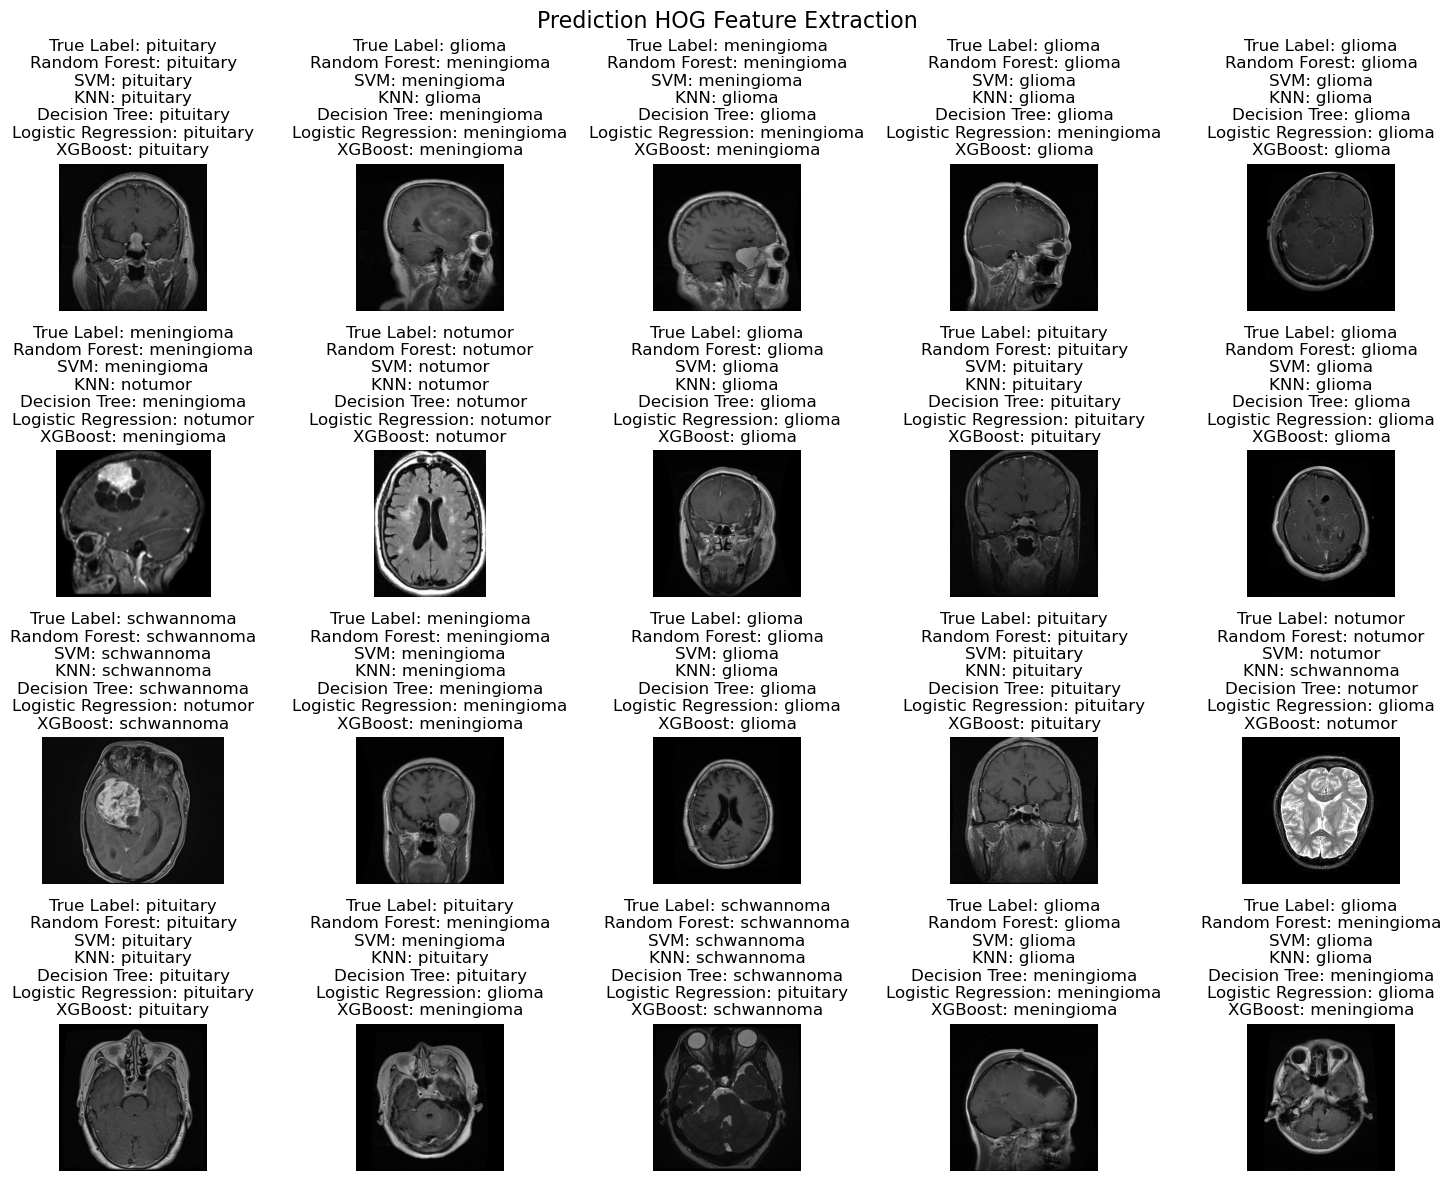

In [19]:
# Load the trained models
model_rf = rf_classifier
model_svm = svm_classifier
model_knn = knn_classifier
model_dt = dt_classifier
model_lr = lr_classifier
model_xgb = xgb_classifier

# Function to predict tumor type for a given image
def predict_tumor_type(model, image):
    # Preprocess the image (resize and extract HOG features)
    image = cv2.resize(image, (image_size, image_size))
    hog_feature, _ = hog(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')
    hog_feature = hog_feature.reshape(1, -1) / 255.0

    # Make prediction
    prediction = model.predict(hog_feature)
    return prediction[0]

# Function to display the image and its predicted tumor type
def display_image_with_prediction_subplot(image, true_label, rf_prediction, svm_prediction, knn_prediction, dt_prediction, lr_prediction, xgb_prediction, index):
    plt.subplot(4, 5, index)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"True Label: {true_label}\nRandom Forest: {rf_prediction}\nSVM: {svm_prediction}\nKNN: {knn_prediction}\nDecision Tree: {dt_prediction}\nLogistic Regression: {lr_prediction}\nXGBoost: {xgb_prediction}")
    plt.axis('off')

plt.figure(figsize=(15, 12))

# Add a title for the entire set of subplots
plt.suptitle("Prediction HOG Feature Extraction", fontsize=16)
# Import random images and display them with predictions
num_images_to_display = 20
random_indices = np.random.choice(len(test_image_paths), num_images_to_display, replace=False)

for i, index in enumerate(random_indices, 1):
    image_path = test_image_paths[index]
    image = cv2.imread(image_path)
    true_label = os.path.basename(os.path.dirname(image_path))

    # Get predictions
    prediction_rf = label_encoder.inverse_transform([predict_tumor_type(model_rf, image)])[0]
    prediction_svm = label_encoder.inverse_transform([predict_tumor_type(model_svm, image)])[0]
    prediction_knn = label_encoder.inverse_transform([predict_tumor_type(model_knn, image)])[0]
    prediction_dt = label_encoder.inverse_transform([predict_tumor_type(model_dt, image)])[0]
    prediction_lr = label_encoder.inverse_transform([predict_tumor_type(model_lr, image)])[0]
    prediction_xgb = label_encoder.inverse_transform([predict_tumor_type(model_xgb, image)])[0]

    display_image_with_prediction_subplot(image, true_label, prediction_rf, prediction_svm, prediction_knn, prediction_dt, prediction_lr, prediction_xgb, i)

plt.tight_layout()
plt.show()


In [20]:
def extract_lbp_features(images):
    lbp_features = []
    for img in tqdm(images):
        # Convert the image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Compute LBP features
        radius = 3
        n_points = 8 * radius
        lbp_feature = local_binary_pattern(gray_img, n_points, radius, method='uniform').ravel()
        lbp_features.append(lbp_feature)
    return np.array(lbp_features)

In [21]:
# Check if the LBP features are already computed and saved
if os.path.exists('X_train_lbp1.npy') and os.path.exists('X_test_lbp1.npy'):
    X_train_lbp = np.load('X_train_lbp1.npy')
    X_test_lbp = np.load('X_test_lbp1.npy')
else:
    # Extract LBP features from training and testing images
    X_train_lbp = extract_lbp_features(X_train)
    X_test_lbp = extract_lbp_features(X_test)

    # Normalize the data (optional but often recommended)
    X_train_lbp = X_train_lbp / 255.0
    X_test_lbp = X_test_lbp / 255.0

    # Save the LBP features to disk
    np.save('X_train_lbp1.npy', X_train_lbp)
    np.save('X_test_lbp1.npy', X_test_lbp)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 736/736 [00:05<00:00, 143.09it/s]


In [22]:
# Apply Random Forest Classifier
rf_classifier_lbp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_lbp.fit(X_train_lbp, y_train_encoded)
rf_predictions_lbp = rf_classifier_lbp.predict(X_test_lbp)

In [23]:
# Apply Support Vector Machine (SVM) Classifier
svm_classifier_lbp = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier_lbp.fit(X_train_lbp, y_train_encoded)
svm_predictions_lbp = svm_classifier_lbp.predict(X_test_lbp)

In [24]:
# Apply K-Nearest Neighbors (KNN) Classifier
knn_classifier_lbp = KNeighborsClassifier(n_neighbors=5)
knn_classifier_lbp.fit(X_train_lbp, y_train_encoded)
knn_predictions_lbp = knn_classifier_lbp.predict(X_test_lbp)

In [25]:
# Apply Decision Tree Classifier
dt_classifier_lbp = DecisionTreeClassifier(random_state=42)
dt_classifier_lbp.fit(X_train_lbp, y_train_encoded)
dt_predictions_lbp = dt_classifier_lbp.predict(X_test_lbp)

In [26]:
# Apply Logistic Regression Classifier
lr_classifier_lbp = LogisticRegression(max_iter=2000, random_state=42)
lr_classifier_lbp.fit(X_train_lbp, y_train_encoded)
lr_predictions_lbp = lr_classifier_lbp.predict(X_test_lbp)

In [27]:
# Apply XGBoost Classifier
xgb_classifier_lbp = XGBClassifier(n_estimators=100, random_state=42)
xgb_classifier_lbp.fit(X_train_lbp, y_train_encoded)
xgb_predictions_lbp = xgb_classifier_lbp.predict(X_test_lbp)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_classifier(predictions, y_true, classifier_name):
    print(f"Evaluation for {classifier_name}:\n")
    print("Classification Report:\n")
    print(classification_report(y_true, predictions, target_names=label_encoder.classes_))
    print("Confusion Matrix:\n")
    print(confusion_matrix(y_true, predictions))

# Evaluate all classifiers
evaluate_classifier(rf_predictions_lbp, y_test_encoded, "Random Forest(LBP)")
evaluate_classifier(svm_predictions_lbp, y_test_encoded, "SVM(LBP)")
evaluate_classifier(knn_predictions_lbp, y_test_encoded, "KNN(LBP)")
evaluate_classifier(dt_predictions_lbp, y_test_encoded, "Decision Tree(LBP)")
evaluate_classifier(lr_predictions_lbp, y_test_encoded, "Logistic Regression(LBP)")
evaluate_classifier(xgb_predictions_lbp, y_test_encoded, "XGBoost(LBP)")


Evaluation for Random Forest(LBP):

Classification Report:

              precision    recall  f1-score   support

      glioma       0.92      0.83      0.88       132
  meningioma       0.82      0.72      0.77       134
 neurocytoma       0.93      0.88      0.90        85
     notumor       0.81      0.97      0.88       160
   pituitary       0.82      0.92      0.87       146
  schwannoma       0.98      0.77      0.87        79

    accuracy                           0.86       736
   macro avg       0.88      0.85      0.86       736
weighted avg       0.87      0.86      0.86       736

Confusion Matrix:

[[110  15   0   0   7   0]
 [  6  97   3   8  20   0]
 [  0   0  75   9   0   1]
 [  1   1   1 155   2   0]
 [  2   6   0   3 135   0]
 [  0   0   2  16   0  61]]
Evaluation for SVM(LBP):

Classification Report:

              precision    recall  f1-score   support

      glioma       0.94      0.86      0.90       132
  meningioma       0.81      0.87      0.84       134
 n

In [29]:
rf_accuracy_lbp = accuracy_score(y_test_encoded, rf_predictions_lbp)
svm_accuracy_lbp = accuracy_score(y_test_encoded, svm_predictions_lbp)
knn_accuracy_lbp = accuracy_score(y_test_encoded, knn_predictions_lbp)
dt_accuracy_lbp = accuracy_score(y_test_encoded, dt_predictions_lbp)
lr_accuracy_lbp = accuracy_score(y_test_encoded, lr_predictions_lbp)
xgb_accuracy_lbp = accuracy_score(y_test_encoded, xgb_predictions_lbp)

In [30]:
# Print accuracies
print(f"Random Forest Accuracy(LBP): {rf_accuracy_lbp:.4f}")
print(f"SVM Accuracy(LBP): {svm_accuracy_lbp:.4f}")
print(f"KNN Accuracy(LBP): {knn_accuracy_lbp:.4f}")
print(f"Decision Tree Accuracy(LBP): {dt_accuracy_lbp:.4f}")
print(f"Logistic Regression Accuracy(LBP): {lr_accuracy_lbp:.4f}")
print(f"XGBoost Accuracy(LBP): {xgb_accuracy_lbp:.4f}")

Random Forest Accuracy(LBP): 0.8601
SVM Accuracy(LBP): 0.9185
KNN Accuracy(LBP): 0.4416
Decision Tree Accuracy(LBP): 0.7391
Logistic Regression Accuracy(LBP): 0.9103
XGBoost Accuracy(LBP): 0.9022


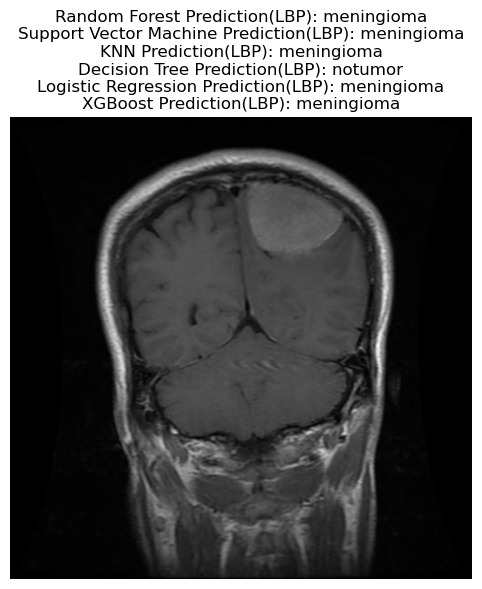

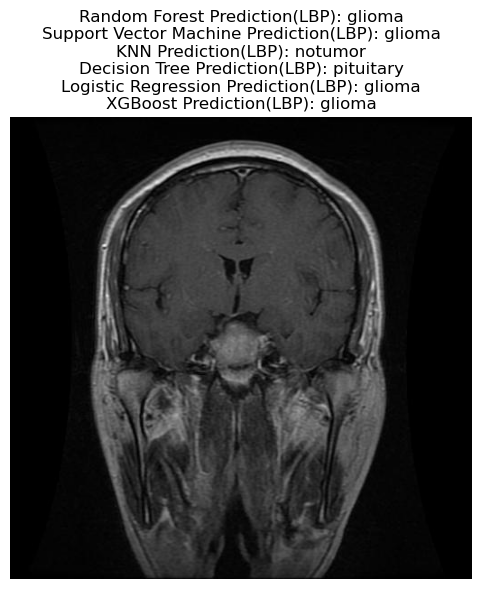

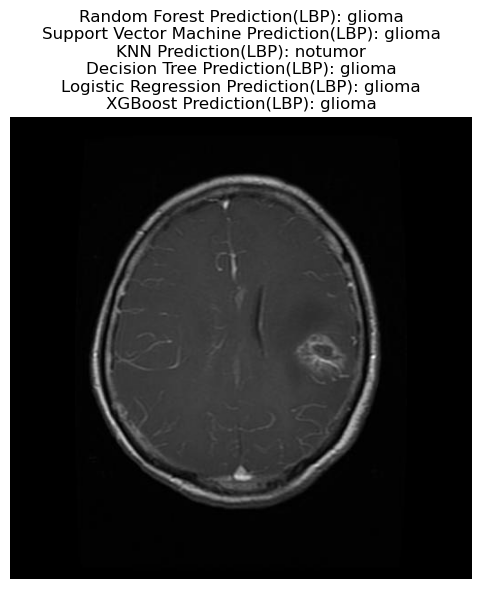

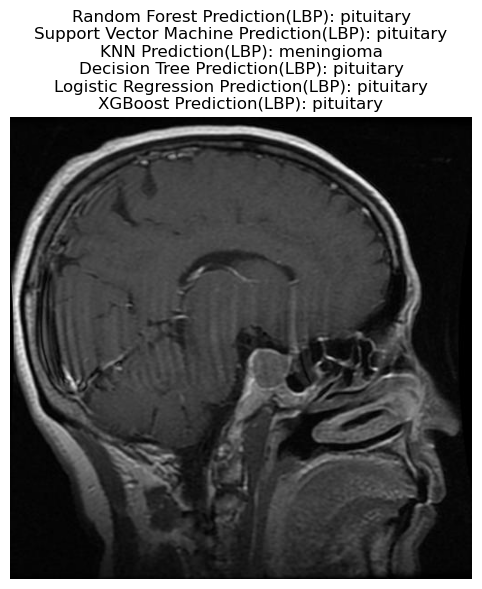

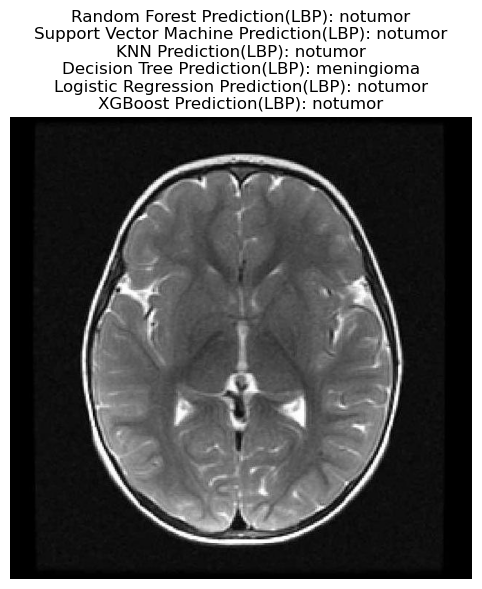

In [31]:
# Load the trained models
model_rf_lbp = rf_classifier_lbp
model_svm_lbp = svm_classifier_lbp
model_knn_lbp = knn_classifier_lbp
model_dt_lbp = dt_classifier_lbp
model_lr_lbp = lr_classifier_lbp
model_xgb_lbp = xgb_classifier_lbp

# Function to predict tumor type for a given image
def predict_tumor_type(model, image):
    # Preprocess the image (resize and extract LBP features)
    image = cv2.resize(image, (image_size, image_size))
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    radius = 3
    n_points = 8 * radius
    lbp_feature = local_binary_pattern(gray_img, n_points, radius, method='uniform').ravel()
    lbp_feature = lbp_feature / 255.0

    # Make prediction
    prediction = model.predict([lbp_feature])
    return prediction[0]

# Function to display the image and its predicted tumor type
def display_image_with_prediction(image):
    prediction_rf_lbp = label_encoder.inverse_transform([predict_tumor_type(model_rf_lbp, image)])[0]
    prediction_svm_lbp = label_encoder.inverse_transform([predict_tumor_type(model_svm_lbp, image)])[0]
    prediction_knn_lbp = label_encoder.inverse_transform([predict_tumor_type(model_knn_lbp, image)])[0]
    prediction_dt_lbp = label_encoder.inverse_transform([predict_tumor_type(model_dt_lbp, image)])[0]
    prediction_lr_lbp = label_encoder.inverse_transform([predict_tumor_type(model_lr_lbp, image)])[0]
    prediction_xgb_lbp = label_encoder.inverse_transform([predict_tumor_type(model_xgb_lbp, image)])[0]

    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Random Forest Prediction(LBP): {prediction_rf_lbp}\nSupport Vector Machine Prediction(LBP): {prediction_svm_lbp}\nKNN Prediction(LBP): {prediction_knn_lbp}\nDecision Tree Prediction(LBP): {prediction_dt_lbp}\nLogistic Regression Prediction(LBP): {prediction_lr_lbp}\nXGBoost Prediction(LBP): {prediction_xgb_lbp}")
    plt.axis('off')
    plt.show()

# Import random images and display them with predictions
test_image_paths = []
for i in labels:
    testfolder = os.path.join('Tumor1/Testing', i)
    test_image_paths.extend([os.path.join(testfolder, j) for j in os.listdir(testfolder)])

# Shuffle the test image paths
test_image_paths = shuffle(test_image_paths)

# Display random images and their predictions
num_images_to_display = 5
for i in range(num_images_to_display):
    image_path = test_image_paths[i]
    image = cv2.imread(image_path)
    display_image_with_prediction(image)

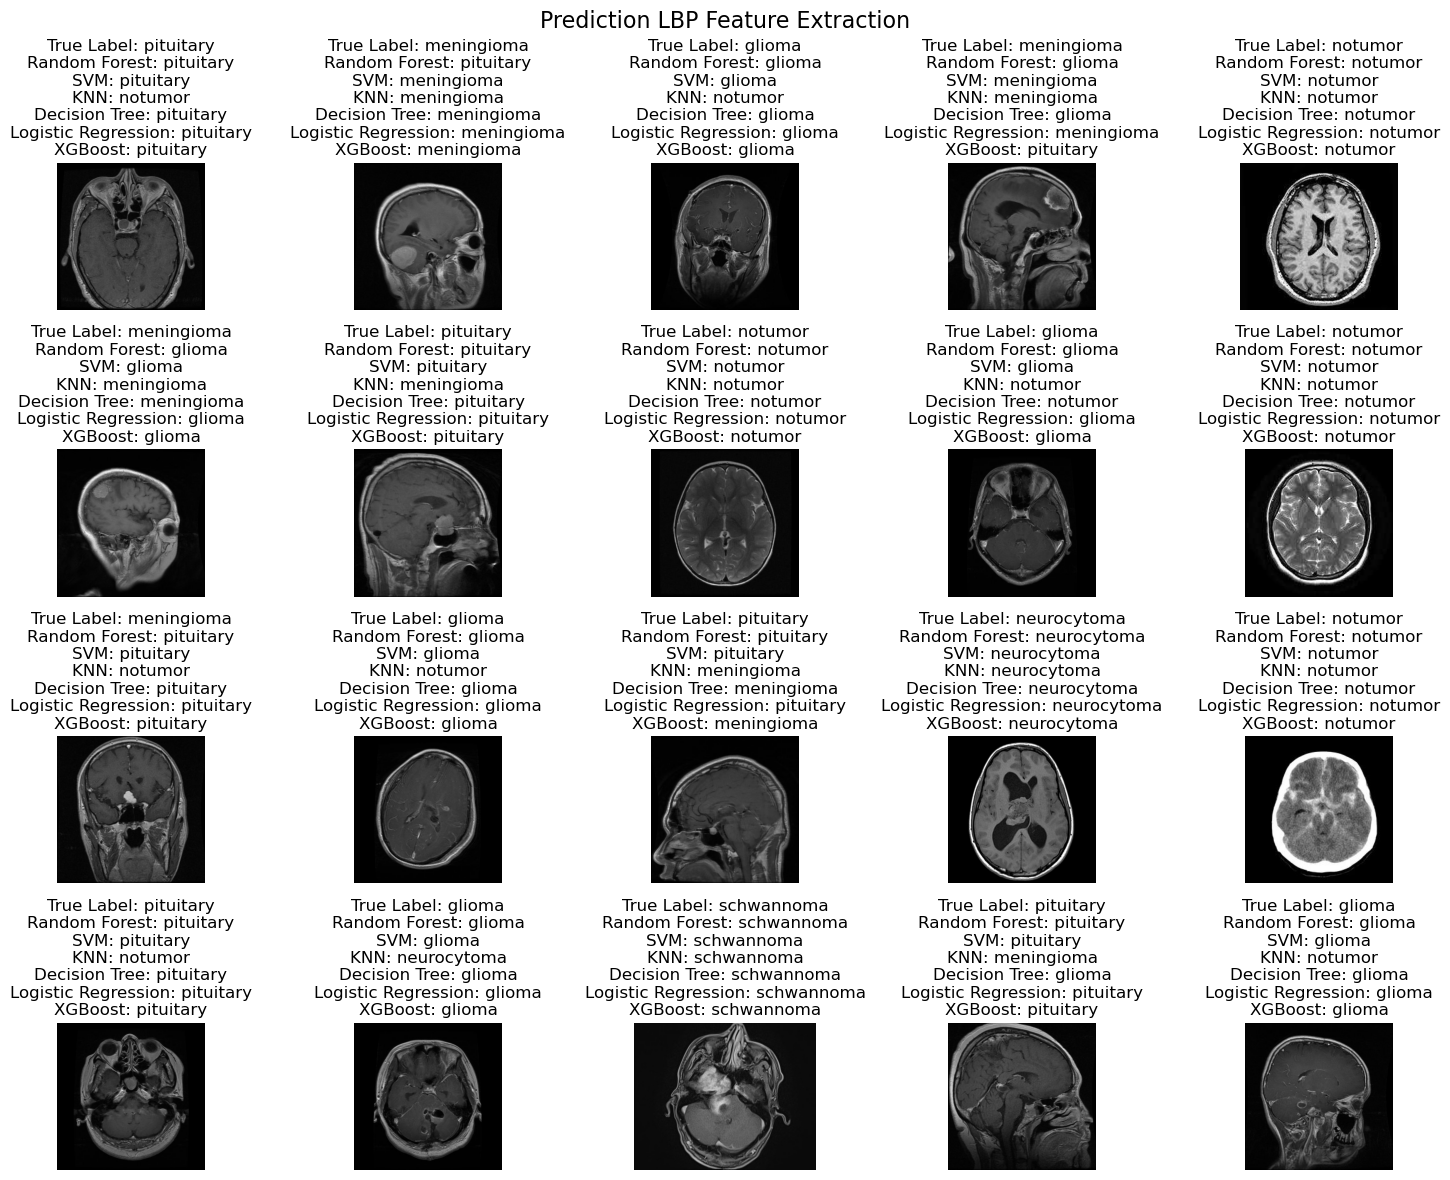

In [32]:
# Load the trained models
model_rf_lbp = rf_classifier_lbp
model_svm_lbp = svm_classifier_lbp
model_knn_lbp = knn_classifier_lbp
model_dt_lbp = dt_classifier_lbp
model_lr_lbp = lr_classifier_lbp
model_xgb_lbp = xgb_classifier_lbp

# Function to predict tumor type for a given image
def predict_tumor_type(model, image):
    # Preprocess the image (resize and extract LBP features)
    image = cv2.resize(image, (image_size, image_size))
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    radius = 3
    n_points = 8 * radius
    lbp_feature = local_binary_pattern(gray_img, n_points, radius, method='uniform').ravel()
    lbp_feature = lbp_feature / 255.0

    # Make prediction
    prediction = model.predict([lbp_feature])
    return prediction[0]

# Function to display the image and its predicted tumor type
def display_image_with_prediction_subplot(image, true_label, rf_prediction_lbp, svm_prediction_lbp, knn_prediction_lbp, dt_prediction_lbp, lr_prediction_lbp, xgb_prediction_lbp, index):
    plt.subplot(4, 5, index)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"True Label: {true_label}\nRandom Forest: {rf_prediction_lbp}\nSVM: {svm_prediction_lbp}\nKNN: {knn_prediction_lbp}\nDecision Tree: {dt_prediction_lbp}\nLogistic Regression: {lr_prediction_lbp}\nXGBoost: {xgb_prediction_lbp}")
    plt.axis('off')

plt.figure(figsize=(15, 12))

# Add a title for the entire set of subplots
plt.suptitle("Prediction LBP Feature Extraction", fontsize=16)

# Import random images and display them with predictions
num_images_to_display = 20
random_indices = np.random.choice(len(test_image_paths), num_images_to_display, replace=False)

for i, index in enumerate(random_indices, 1):
    image_path = test_image_paths[index]
    image = cv2.imread(image_path)
    true_label = os.path.basename(os.path.dirname(image_path))

    # Get predictions
    prediction_rf_lbp = label_encoder.inverse_transform([predict_tumor_type(model_rf_lbp, image)])[0]
    prediction_svm_lbp = label_encoder.inverse_transform([predict_tumor_type(model_svm_lbp, image)])[0]
    prediction_knn_lbp = label_encoder.inverse_transform([predict_tumor_type(model_knn_lbp, image)])[0]
    prediction_dt_lbp = label_encoder.inverse_transform([predict_tumor_type(model_dt_lbp, image)])[0]
    prediction_lr_lbp = label_encoder.inverse_transform([predict_tumor_type(model_lr_lbp, image)])[0]
    prediction_xgb_lbp = label_encoder.inverse_transform([predict_tumor_type(model_xgb_lbp, image)])[0]

    display_image_with_prediction_subplot(image, true_label, prediction_rf_lbp, prediction_svm_lbp, prediction_knn_lbp, prediction_dt_lbp, prediction_lr_lbp, prediction_xgb_lbp, i)

plt.tight_layout()
plt.show()

In [34]:
import joblib
joblib.dump(rf_classifier, "./random_forest(hog).joblib")
joblib.dump(svm_classifier, "./SVM(hog).joblib")
joblib.dump(knn_classifier, "./knn(hog).joblib")
joblib.dump(dt_classifier, "./decision tree(hog).joblib")
joblib.dump(lr_classifier, "./LogisticRegression(hog).joblib")
joblib.dump(xgb_classifier, "./Xgb(hog).joblib")

joblib.dump(rf_classifier_lbp , "./random_forest(lbp).joblib")
joblib.dump(svm_classifier_lbp , "./SVM(lbp).joblib")
joblib.dump(knn_classifier_lbp , "./knn(lbp).joblib")
joblib.dump(dt_classifier_lbp , "./decision tree(lbp).joblib")
joblib.dump(lr_classifier_lbp , "./LogisticRegression(lbp).joblib")
joblib.dump(xgb_classifier_lbp , "./Xgb(lbp).joblib")

['./Xgb(lbp).joblib']

In [8]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
import joblib
from sklearn.preprocessing import LabelEncoder
image_size = 256

# Load the trained models (you need to load these models first)
model_rf_lbp = joblib.load("random_forest(lbp).joblib")
model_svm_lbp = joblib.load("SVM(lbp).joblib")
model_knn_lbp = joblib.load("knn(lbp).joblib")
model_dt_lbp = joblib.load("decision tree(lbp).joblib")
model_lr_lbp = joblib.load("LogisticRegression(lbp).joblib")
model_xgb_lbp = joblib.load("Xgb(lbp).joblib")

# Define the label encoder (you need to have the label encoder defined)
class_names = ['glioma', 'meningioma', 'neurocytoma', 'notumor', 'pituitary', 'schwannoma'] # Replace with your class names
label_encoder = LabelEncoder()
label_encoder.fit(class_names)

# Function to predict tumor type for a given image
def predict_tumor_type(model, image):
    # Preprocess the image (resize and extract LBP features)
    image = cv2.resize(image, (image_size, image_size))
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    radius = 3
    n_points = 8 * radius
    lbp_feature = local_binary_pattern(gray_img, n_points, radius, method='uniform').ravel()
    lbp_feature = lbp_feature / 255.0

    # Make prediction
    prediction = model.predict([lbp_feature])
    return prediction[0]

# Function to display the image and its predicted tumor type
def display_image_with_prediction_subplot(image, true_label, rf_prediction_lbp, svm_prediction_lbp, knn_prediction_lbp, dt_prediction_lbp, lr_prediction_lbp, xgb_prediction_lbp, index):
    plt.subplot(4, 5, index)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"True Label: {true_label}\nRandom Forest: {rf_prediction_lbp}\nSVM: {svm_prediction_lbp}\nKNN: {knn_prediction_lbp}\nDecision Tree: {dt_prediction_lbp}\nLogistic Regression: {lr_prediction_lbp}\nXGBoost: {xgb_prediction_lbp}")
    plt.axis('off')

plt.figure(figsize=(15, 12))
plt.suptitle("Prediction LBP Feature Extraction", fontsize=16)

# List of specific image paths you want to use for prediction
specific_image_paths = [
    "Tumor1/Testing/meningioma/Te-meTr_0009.jpg"
]

for i, image_path in enumerate(specific_image_paths, 1):
    image = cv2.imread(image_path)
    true_label = os.path.basename(os.path.dirname(image_path))

    # Get predictions
    prediction_rf_lbp = label_encoder.inverse_transform([predict_tumor_type(model_rf_lbp, image)])[0]
    prediction_svm_lbp = label_encoder.inverse_transform([predict_tumor_type(model_svm_lbp, image)])[0]
    prediction_knn_lbp = label_encoder.inverse_transform([predict_tumor_type(model_knn_lbp, image)])[0]
    prediction_dt_lbp = label_encoder.inverse_transform([predict_tumor_type(model_dt_lbp, image)])[0]
    prediction_lr_lbp = label_encoder.inverse_transform([predict_tumor_type(model_lr_lbp, image)])[0]
    prediction_xgb_lbp = label_encoder.inverse_transform([predict_tumor_type(model_xgb_lbp, image)])[0]

    display_image_with_prediction_subplot(image, true_label, prediction_rf_lbp, prediction_svm_lbp, prediction_knn_lbp, prediction_dt_lbp, prediction_lr_lbp, prediction_xgb_lbp, i)

plt.tight_layout()
plt.show()


[ WARN:0@262.244] global loadsave.cpp:248 findDecoder imread_('Tumor1/Testing/meningioma/Te-meTr_0009.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.8.0) /Users/xperience/GHA-OpenCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


<Figure size 1500x1200 with 0 Axes>